# An implementation of the Ant miner paper for Emotion Recognition

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import (FigureCanvasTkAgg, 
NavigationToolbar2Tk)
import copy
from tkinter import *
from tkinter import ttk
from pandastable import Table

In [86]:
df = pd.read_csv("Resources/Ravdess Dataset.csv")
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f643,f644,f645,f646,f647,f648,f649,f650,f651,class
0,-675.852,-820.630,-372.474,156.448,0.455,-1.471,68.959,-15.910,217.757,72.966,...,15.036,-3.957,32.880,0.023,-110.137,112.829,20.504,-0.442,17.036,neutral
1,-640.294,-783.178,-358.277,154.661,0.411,-1.555,64.627,-47.438,218.073,76.974,...,12.265,-4.655,30.513,-0.725,-82.309,67.398,13.982,-1.941,19.824,neutral
2,-677.497,-825.274,-375.799,157.171,0.415,-1.537,66.738,-79.028,208.915,73.381,...,22.398,-2.424,37.887,-0.037,-169.023,170.742,30.984,0.124,18.527,neutral
3,-659.499,-809.578,-356.445,164.199,0.455,-1.502,61.317,-70.403,214.674,75.767,...,10.528,1.095,18.721,-0.004,-59.714,50.999,13.634,-0.887,10.296,neutral
4,-698.072,-857.808,-409.923,156.816,0.281,-1.594,70.695,-55.799,221.357,70.646,...,24.944,-2.291,42.875,0.022,-253.151,210.330,35.594,-0.635,28.814,calm


In [87]:
#Level of discretization of the continuous data
bins = 3

(array([364., 845., 231.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

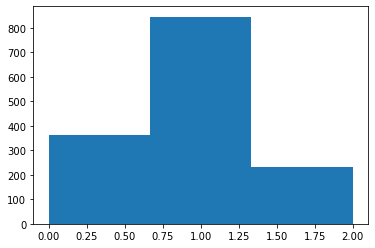

In [88]:
plt.hist(pd.cut(df['f0'], bins=bins, labels=range(bins)), bins = bins)

(array([480., 480., 480.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

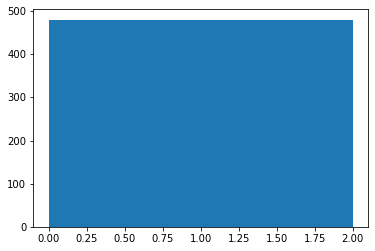

In [89]:
plt.hist(pd.qcut(df['f0'], q=bins, labels=range(bins)), bins = bins)

In [90]:
discreet = pd.DataFrame()

In [91]:
for column in df.drop('class', axis=1).columns:
    #discreet[column] = pd.cut(df[column], bins=bins, labels=range(bins))
    discreet[column] = pd.qcut(df[column], q=bins, duplicates='drop')

In [92]:
temp_bins = discreet.nunique()

In [93]:
for column in df.drop('class', axis=1).columns:
    #discreet[column] = pd.cut(df[column], bins=bins, labels=range(bins))
    discreet[column] = pd.qcut(df[column], q=bins, duplicates='drop', labels=range(temp_bins[column]))

In [94]:
discreet = discreet.astype(float)

In [95]:
discreet = discreet.fillna(0)

In [96]:
discreet = discreet.astype(int)

In [97]:
discreet['class'] = df['class']

In [98]:
emotions = discreet['class'].unique()
emotions

array(['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust',
       'surprised'], dtype=object)

In [99]:
train, test = np.split(discreet.sample(frac=1), [int(0.75*len(discreet))])
train_len = len(train)
test_len = len(test)
total_len = train_len + test_len
test_len, train_len, total_len

(360, 1080, 1440)

# Entropy values
H will be a matrix of size (bins x features). Computed in a vectorized way to save time (This would take like 10 mins if it was in a for loop, now it takes 10s). <br>
Ok fine I'm looping through the 6 emotions so techhhhnically it's not fully vectorized. Anyway we're computing H only once so I took lite

In [100]:
H = np.zeros((bins, len(train.columns)-1, len(emotions)))

In [101]:
# The most compute intensive step
for e, emotion in enumerate(emotions):
            H[:, :, e] = train.loc[train['class']==emotion].drop('class', axis=1).apply(pd.Series.value_counts).fillna(0).to_numpy()
#H

In [102]:
sums = np.sum(H, axis=2)
#sums

In [103]:
repeated_sums = np.repeat(sums[:, :, np.newaxis], H.shape[2], axis=2)
#repeated_sums[:, :, 1]

In [104]:
P = np.divide(H, repeated_sums, out=np.zeros_like(H), where=repeated_sums!=0)

In [105]:
logP = np.log2(P, out=np.zeros_like(P), where=P>0)
#logP

In [106]:
H = -np.sum(np.multiply(P, logP), axis=2)
#H

In [107]:
np.where(np.isnan(H))

(array([], dtype=int64), array([], dtype=int64))

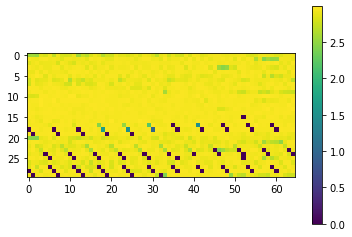

In [108]:
vis = H[:, :-2]
vis = vis.reshape(30,65)
plt.imshow(vis)
plt.colorbar()
plt.show()

In [109]:
features = discreet.drop('class', axis=1).columns
logK = np.log2(len(emotions))

In [111]:
class Window:
    def __init__(self,title,geometry):
        self.w = Tk()
        self.w.title(title)
        self.w.option_add('*Font','25')
        self.w.geometry(geometry)
        self.frame = ttk.Frame(self.w, padding="12 12 12 12")
        self.progress = ttk.Frame(self.w, padding="12 12 12 12")
        self.dataframe = ttk.Frame(self.w,padding="12 12 12 12")
        self.tf  = ttk.Frame(self.w, padding="12 12 12 12")
        self.frame.place(relx=0.1,rely=0.2)
        self.tf.place(relx=0.3725,rely=0.26146789)
        self.dataframe.place(relx=0.8,rely=0.4)
        self.progress.place(relx=0.75, rely=0.6)
    
    def label(self,text):
        ttk.Label(self.frame,text=str(text),wraplength=600).pack()
    
    def exit_button(self,text="Next"):
        self.exit = ttk.Button(self.frame,text=text,command=self.w.destroy)
        self.exit.pack()
        

In [112]:
class Rule:
    def __init__(self, train_set):
        self.terms = {}
        self.emotion = None
        self.numerosity = 0
        self.train_set = train_set
        self.match_set = train_set
    
    def match(self, instance):
        for key, value in instance.items():
            if key in self.terms and self.terms[key] != value:
                return False
        return True
    
    def new_match_set(self, term):
        return self.match_set.loc[self.match_set['f' + str(term['feature'])] == term['class']]
    
    def unmatch_set(self):
        return pd.concat([self.train_set, self.match_set, self.match_set]).drop_duplicates(keep=False)
    
    def correct_set(self):
        return self.match_set.loc[self.match_set['class'] == self.emotion]
    
    def exists(self, feature):
        return feature in self.terms
            
    def addTerm(self, term, new_matches):
        self.terms[term['feature']] = term['class']
        self.match_set = new_matches
        self.numerosity += 1
        
    def quality(self):
        matches = self.match_set
        unmatches = self.unmatch_set()
        TP = len(matches.loc[matches['class'] == self.emotion])
        FP = len(matches.loc[matches['class'] != self.emotion])
        FN = len(unmatches.loc[unmatches['class'] == self.emotion])
        TN = len(unmatches.loc[unmatches['class'] != self.emotion])
        
        sens = TP / (TP + FN)
        spec = TN / (FP + TN)
        
        return sens * spec
        
    def prune(self):
        pass
        

In [113]:
def normalize_probs(probs):
    return probs / np.sum(probs)

In [114]:
class Ant:
    def __init__(self, index, train_set, n_tries, min_coverage):
        self.index = index
        self.rule = Rule(train_set)
        self.n_tries = n_tries
        self.min_coverage = min_coverage
    
    def traverse(self, T):
        x = len(features) - self.rule.numerosity
        Eta = logK - H
        denom = x * np.sum(Eta, axis=0)
        Eta = np.divide(Eta, denom)
        
        Probs = np.multiply(Eta, T)
        denom = x * np.sum(Probs, axis=0)
        Probs = np.divide(Probs, denom)
        
        should_continue = True
        while(should_continue):
            tries = self.n_tries
            flattened = Probs.flatten()
            while(tries):
                chosen = int(np.random.choice(len(flattened), 1, p=flattened))
                term = {'feature': chosen % len(features), 'class': chosen // len(features)}
                new_cov = self.rule.new_match_set(term)
                if len(new_cov) >= self.min_coverage:
                    self.rule.addTerm(term, new_cov)
                    print("Added " + str(term))
                    
                    Probs[:, term['feature']] = 0
                    Probs = normalize_probs(Probs)
                    
                    should_continue = True
                    break
                tries -= 1
                should_continue = False
                
    def set_emotion(self):
        matches = self.rule.match_set
        self.rule.emotion = matches['class'].mode()[0]
        

In [131]:
class World:
    def __init__(
        self,
        min_coverage = 10,
        max_uncovered = 10,
        n_ants = 500,
        max_dups = 1,
        tries = 10,
        train_set = train.copy(deep=True),
    ):
    
        self.min_coverage = min_coverage
        self.max_uncovered = max_uncovered
        self.n_ants = n_ants
        self.max_dups = max_dups
        self.chances_before_brutally_murdering_ant = tries
        self.train_set = train_set
        self.pheromone_map = np.ones_like(H) * (1 / (bins * len(features)))
        self.discovered_rule_list = []

    def deposit_pheromones(self, new_pheromones):
        self.pheromone_map = self.pheromone_map + new_pheromones
        
    def evaporate_pheromones(self):
        self.pheromone_map = self.pheromone_map / np.sum(self.pheromone_map)
        
    def plot_pheromones(self, a):
        vis = self.pheromone_map[:, :-2]
        vis = vis.reshape(30,65)
#         plt.imshow(vis)
#         plt.colorbar()
#         plt.savefig('Plots/Generation' + str(len(self.discovered_rule_list)) + 'ant' + str(a))
#         plt.clf()
        
        for widget in win.tf.winfo_children():
            widget.destroy()
        for widget in win.dataframe.winfo_children():
            widget.destroy()

        figure = plt.figure(figsize=(5,5),dpi=100)
        plot = figure.add_subplot(111)
        bar = plot.imshow(vis)
        figure.colorbar(bar)

        canvas = FigureCanvasTkAgg(figure,win.tf)
        canvas.get_tk_widget().grid()
        
        ttk.Label(win.dataframe,text=str("Current generation: "+str(len(self.discovered_rule_list)+1))).pack()
        ttk.Label(win.dataframe,text=str("Current ant number: "+str(a+1))).pack()

        win.w.update()
    
    def dispatch_ants(self):
        prev_rules = []
        prev_qualities = []
        dups = 0
        for a in range(self.n_ants):
            ant = Ant(a, self.train_set, self.chances_before_brutally_murdering_ant, self.min_coverage)
            print("initialized ant " + str(a))
            ant.traverse(self.pheromone_map)
            ant.set_emotion()
            
            for prev_rule in prev_rules:
                if ant.rule == prev_rule:
                    dups += 1
                    break
            else:
                Q = ant.rule.quality()

                mask = np.zeros_like(H)
                mask[list(ant.rule.terms.values()), list(ant.rule.terms)] = 1
                
                self.deposit_pheromones(np.multiply(self.pheromone_map, mask) * Q)
                self.evaporate_pheromones()

                if a%10 == 0:
                    self.plot_pheromones(a)

                prev_rules.append(ant.rule)
                prev_qualities.append(Q)
                
            if dups > self.max_dups:
                break

        imax = np.argmax(prev_qualities)
        
        return prev_rules[imax]
    
    def discover_rules(self):
        while(len(self.train_set) > self.max_uncovered):
            best_rule = self.dispatch_ants()
            self.discovered_rule_list.append(best_rule)
            corrects = best_rule.correct_set()
            self.train_set = pd.concat([self.train_set, corrects, corrects]).drop_duplicates(keep=False)

In [135]:
def Worldgen(*args):
    a = min_coverage.get()
    b = max_uncovered.get()
    c = n_ants.get()
    d = max_dups.get()
    e = chance_murder_ant.get()
    world = World(min_coverage=a,max_uncovered=b,n_ants=c,max_dups=d,tries=e)
    world.discover_rules()
    run.destroy()
    win.exit_button()

initialized ant 0
Added {'feature': 259, 'class': 2}
Added {'feature': 148, 'class': 0}
Added {'feature': 644, 'class': 1}
Added {'feature': 93, 'class': 1}
initialized ant 1
Added {'feature': 400, 'class': 0}
Added {'feature': 90, 'class': 2}
Added {'feature': 53, 'class': 0}
Added {'feature': 543, 'class': 2}
initialized ant 2
Added {'feature': 560, 'class': 0}
Added {'feature': 158, 'class': 1}
Added {'feature': 179, 'class': 0}
Added {'feature': 548, 'class': 0}
Added {'feature': 246, 'class': 0}
initialized ant 3
Added {'feature': 605, 'class': 2}
Added {'feature': 6, 'class': 0}
Added {'feature': 419, 'class': 0}
Added {'feature': 588, 'class': 1}
Added {'feature': 149, 'class': 0}
initialized ant 4
Added {'feature': 643, 'class': 2}
Added {'feature': 292, 'class': 2}
Added {'feature': 527, 'class': 2}
Added {'feature': 506, 'class': 2}
Added {'feature': 647, 'class': 0}
initialized ant 5
Added {'feature': 510, 'class': 0}
Added {'feature': 331, 'class': 0}
Added {'feature': 131,

C:\ProgramData\Anaconda3\envs\ga-aco\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


initialized ant 22
Added {'feature': 26, 'class': 0}
Added {'feature': 572, 'class': 1}
Added {'feature': 314, 'class': 2}
Added {'feature': 524, 'class': 0}
initialized ant 23
Added {'feature': 356, 'class': 2}
Added {'feature': 515, 'class': 0}
Added {'feature': 529, 'class': 0}
Added {'feature': 347, 'class': 2}
Added {'feature': 528, 'class': 0}
initialized ant 24
Added {'feature': 183, 'class': 2}
Added {'feature': 376, 'class': 2}
Added {'feature': 500, 'class': 1}
Added {'feature': 591, 'class': 2}
initialized ant 25
Added {'feature': 65, 'class': 0}
Added {'feature': 269, 'class': 1}
Added {'feature': 201, 'class': 2}
Added {'feature': 608, 'class': 1}
initialized ant 26
Added {'feature': 621, 'class': 2}
Added {'feature': 545, 'class': 2}
Added {'feature': 266, 'class': 2}
Added {'feature': 91, 'class': 0}
Added {'feature': 94, 'class': 0}
initialized ant 27
Added {'feature': 39, 'class': 2}
Added {'feature': 393, 'class': 1}
Added {'feature': 411, 'class': 2}
Added {'feature'

initialized ant 71
Added {'feature': 584, 'class': 2}
Added {'feature': 146, 'class': 0}
Added {'feature': 316, 'class': 2}
Added {'feature': 126, 'class': 0}
Added {'feature': 607, 'class': 0}
initialized ant 72
Added {'feature': 233, 'class': 1}
Added {'feature': 192, 'class': 2}
initialized ant 73
Added {'feature': 199, 'class': 0}
Added {'feature': 615, 'class': 1}
Added {'feature': 13, 'class': 0}
Added {'feature': 417, 'class': 0}
initialized ant 74
Added {'feature': 73, 'class': 0}
Added {'feature': 573, 'class': 2}
Added {'feature': 605, 'class': 1}
Added {'feature': 227, 'class': 1}
initialized ant 75
Added {'feature': 242, 'class': 1}
Added {'feature': 178, 'class': 2}
Added {'feature': 400, 'class': 2}
Added {'feature': 304, 'class': 0}
initialized ant 76
Added {'feature': 647, 'class': 0}
Added {'feature': 123, 'class': 0}
Added {'feature': 41, 'class': 0}
Added {'feature': 415, 'class': 2}
Added {'feature': 444, 'class': 2}
Added {'feature': 110, 'class': 2}
Added {'featur

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\ga-aco\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "C:\Users\Pranav\AppData\Local\Temp/ipykernel_29716/3133638096.py", line 8, in Worldgen
    world.discover_rules()
  File "C:\Users\Pranav\AppData\Local\Temp/ipykernel_29716/3342259949.py", line 91, in discover_rules
    best_rule = self.dispatch_ants()
  File "C:\Users\Pranav\AppData\Local\Temp/ipykernel_29716/3342259949.py", line 77, in dispatch_ants
    self.plot_pheromones(a)
  File "C:\Users\Pranav\AppData\Local\Temp/ipykernel_29716/3342259949.py", line 35, in plot_pheromones
    for widget in win.tf.winfo_children():
  File "C:\ProgramData\Anaconda3\envs\ga-aco\lib\tkinter\__init__.py", line 959, in winfo_children
    self.tk.call('winfo', 'children', self._w)):
_tkinter.TclError: can't invoke "winfo" command: application has been destroyed


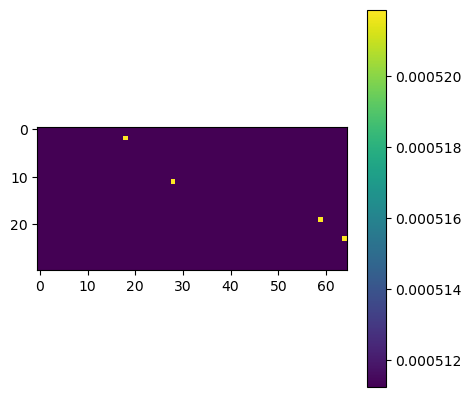

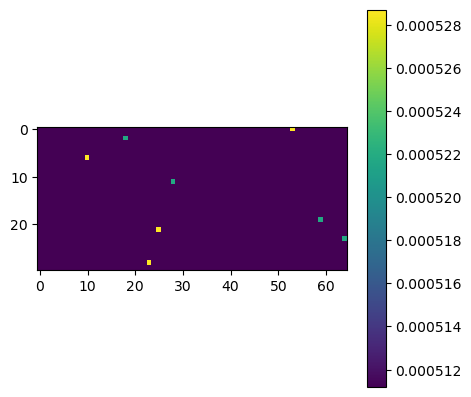

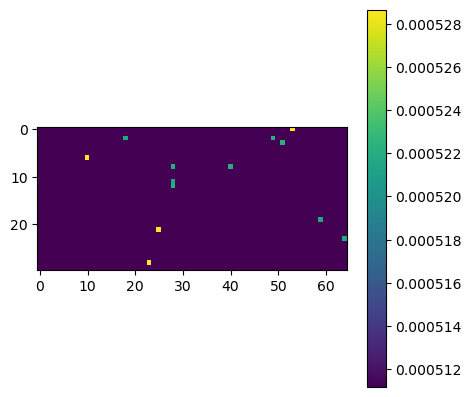

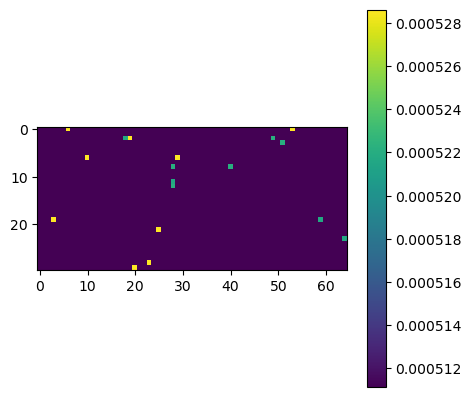

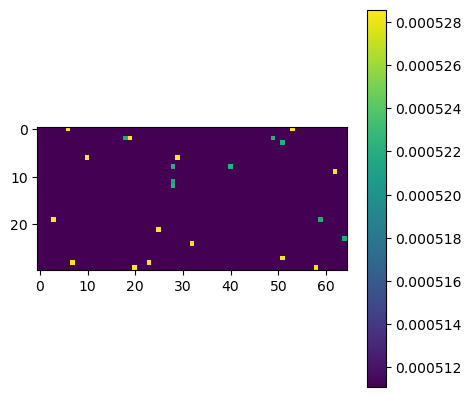

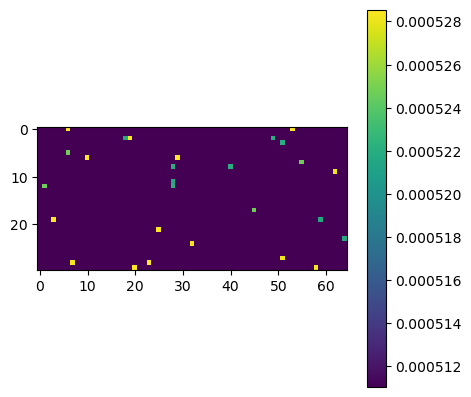

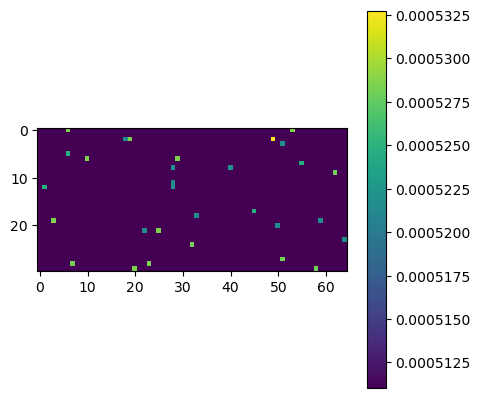

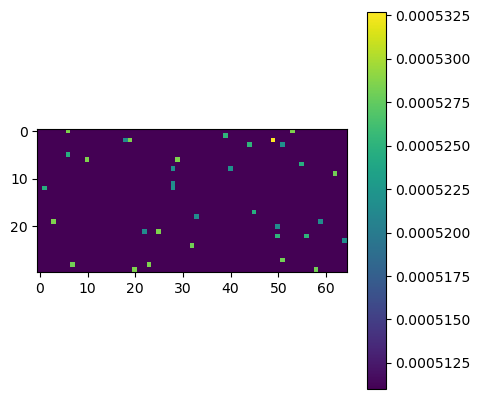

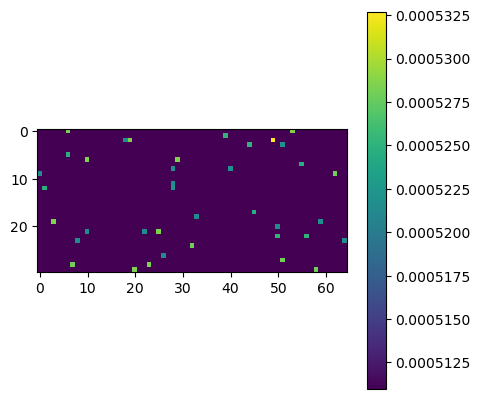

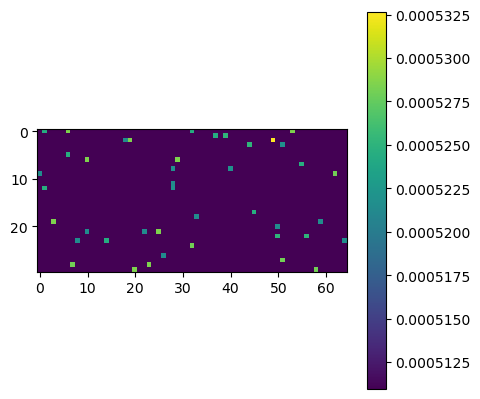

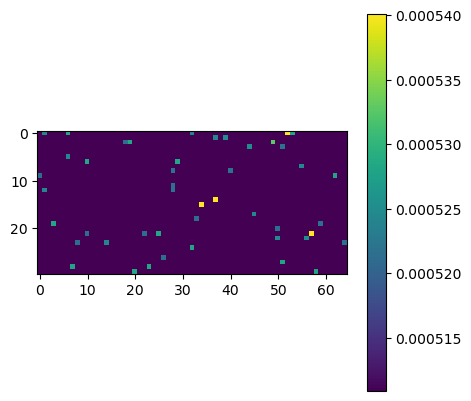

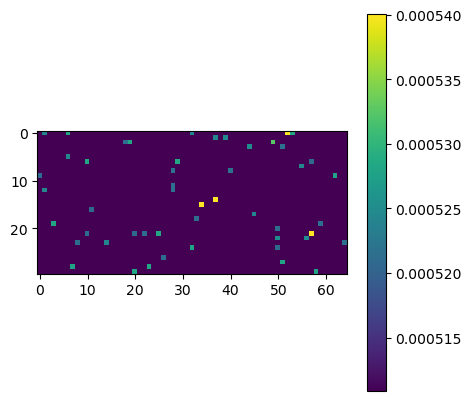

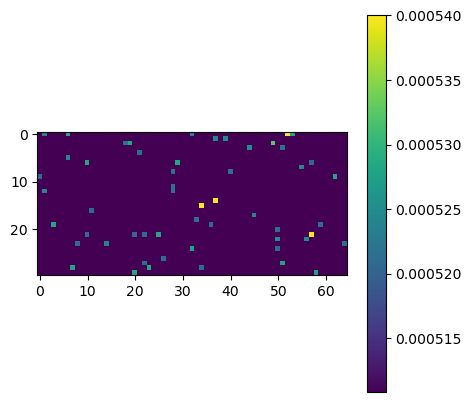

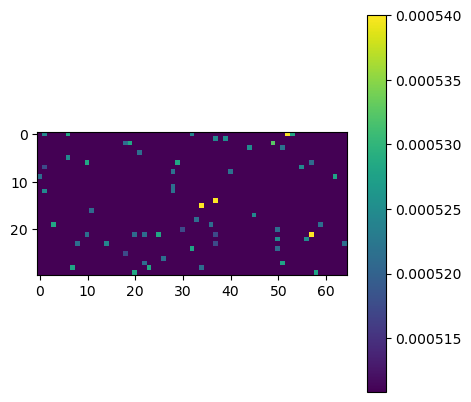

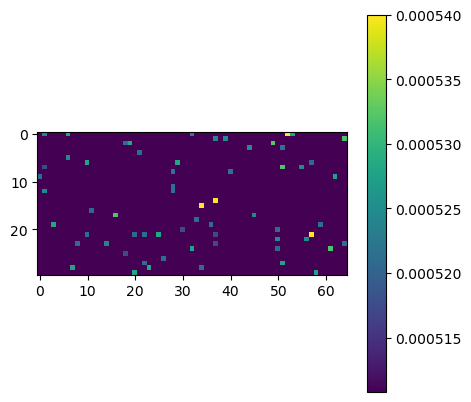

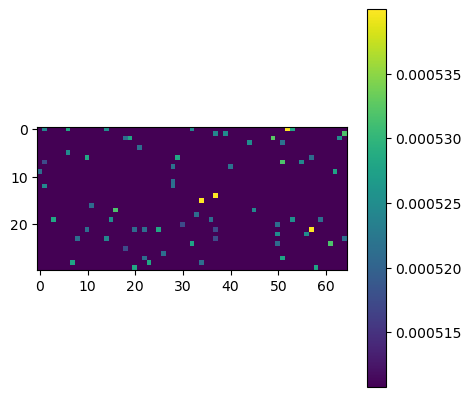

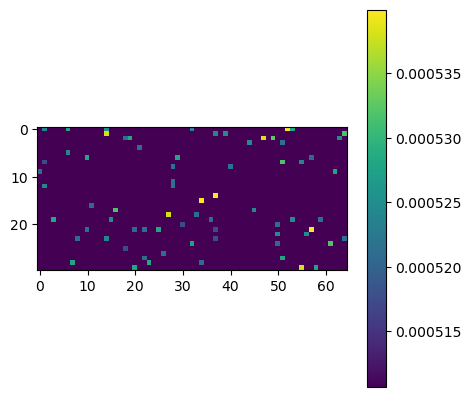

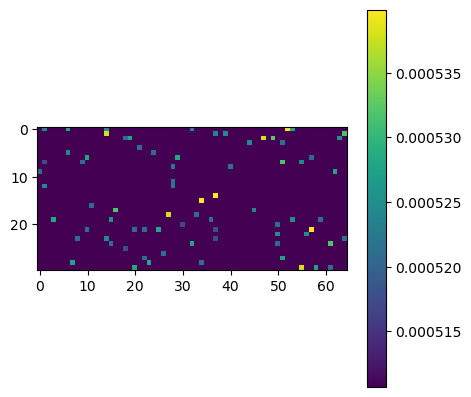

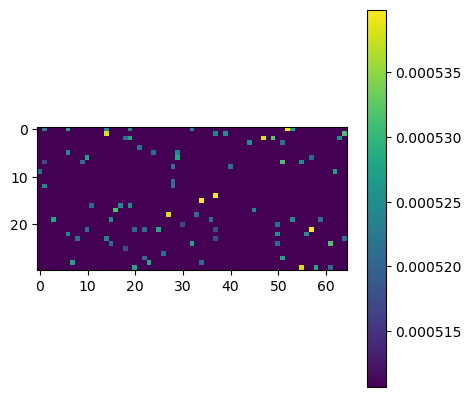

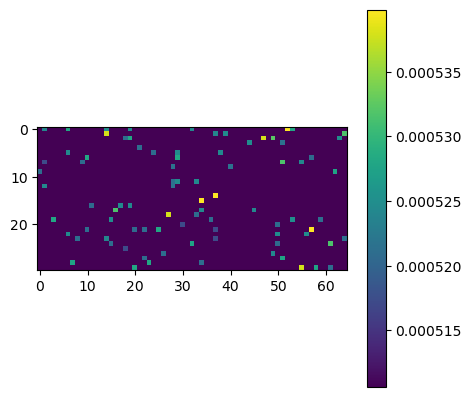

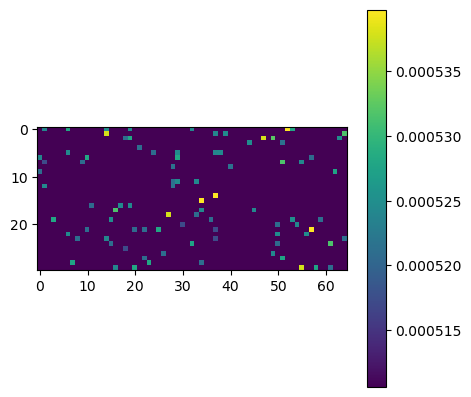

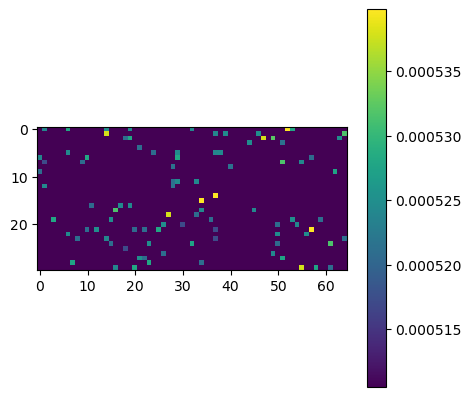

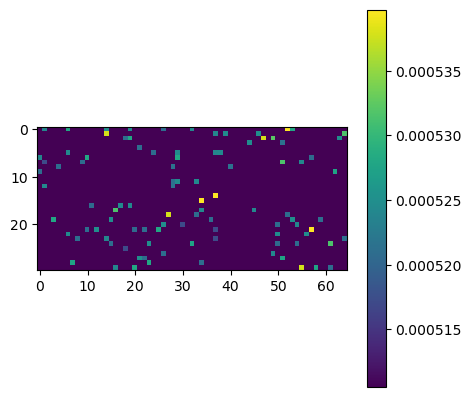

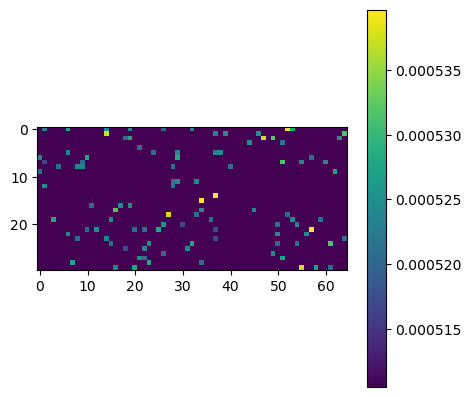

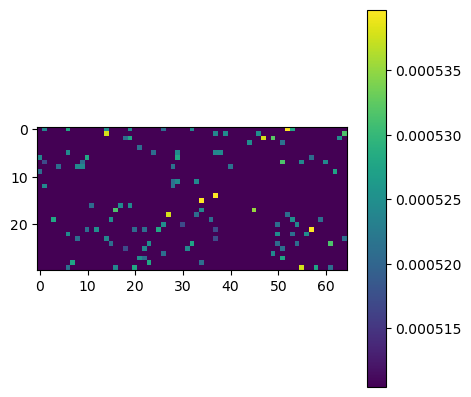

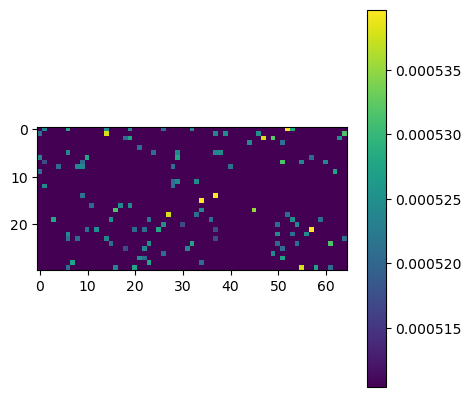

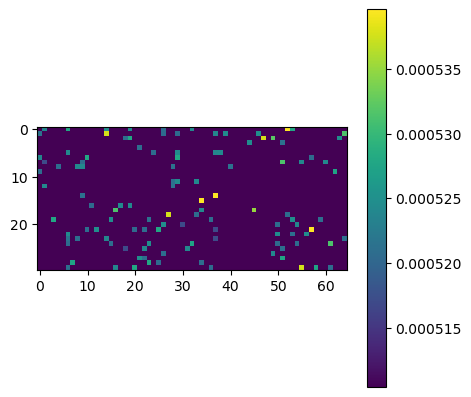

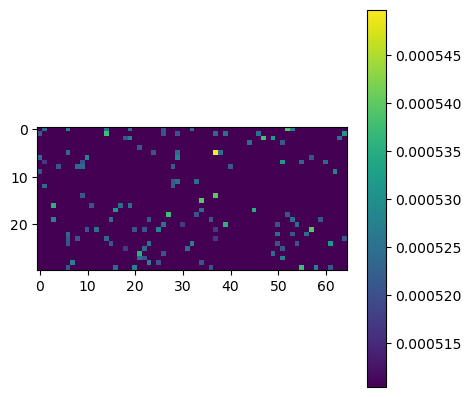

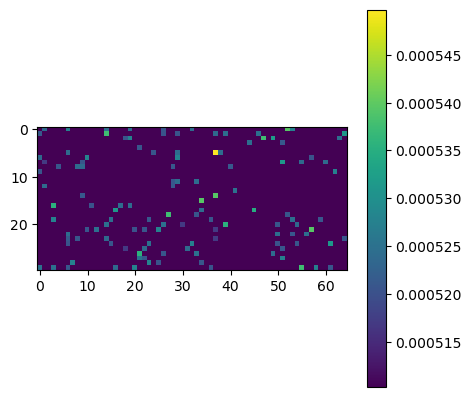

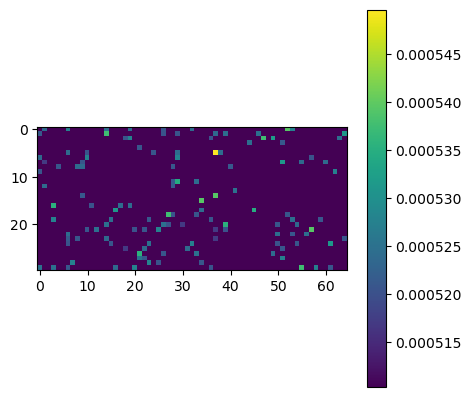

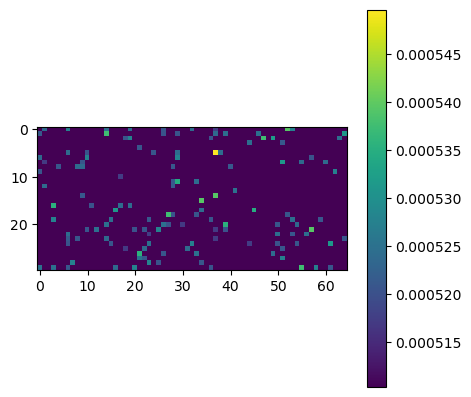

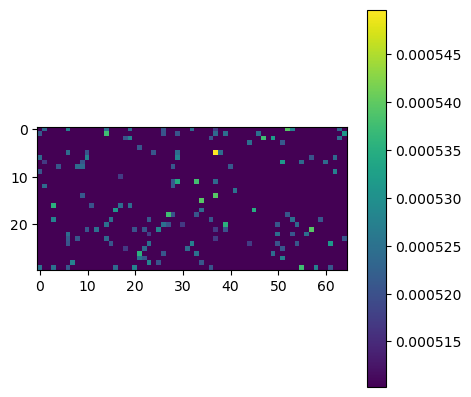

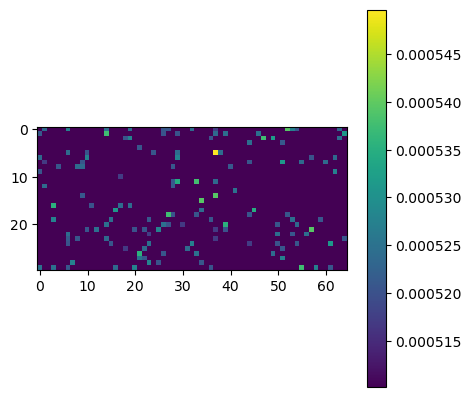

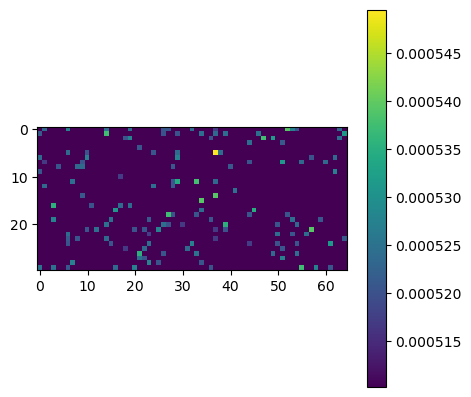

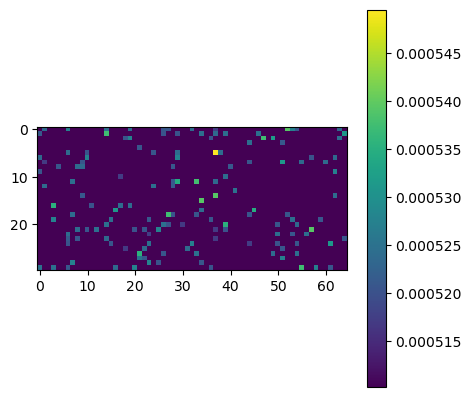

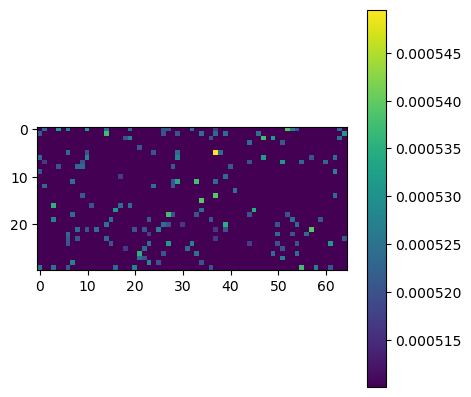

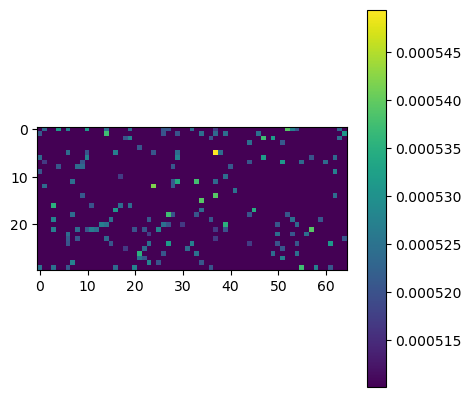

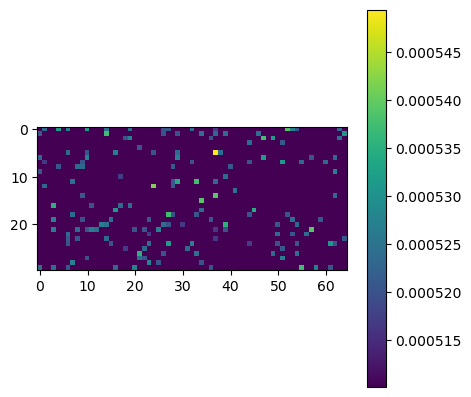

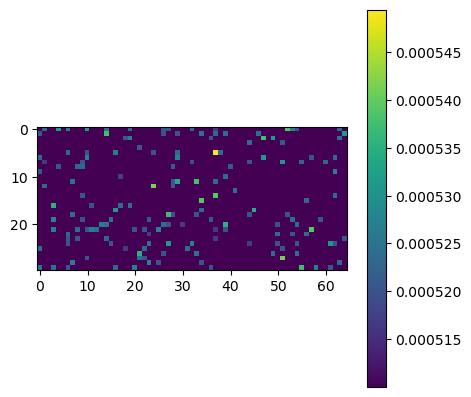

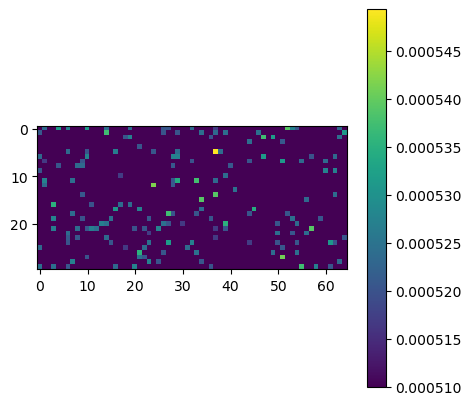

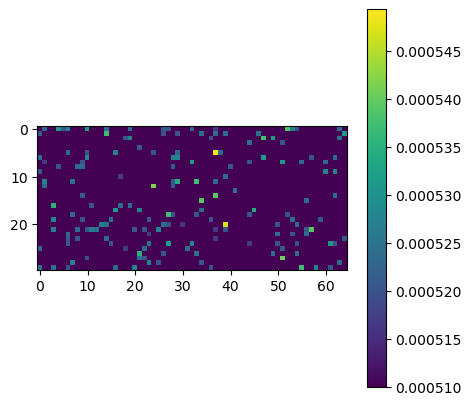

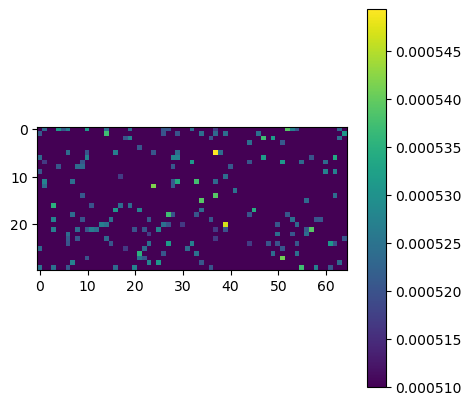

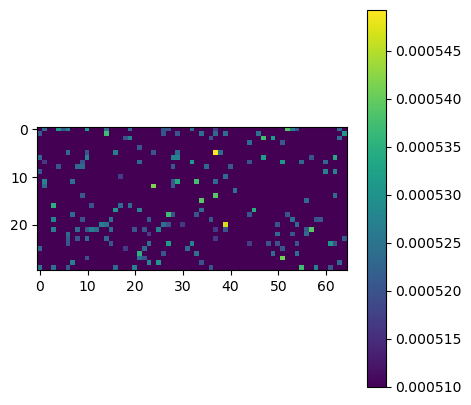

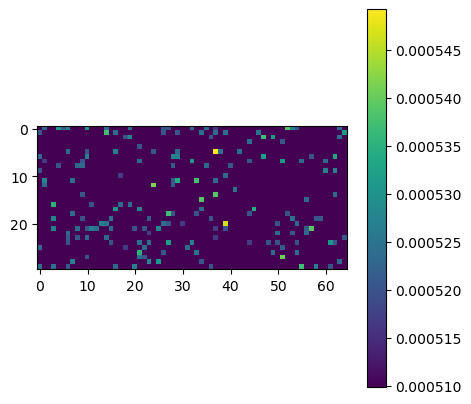

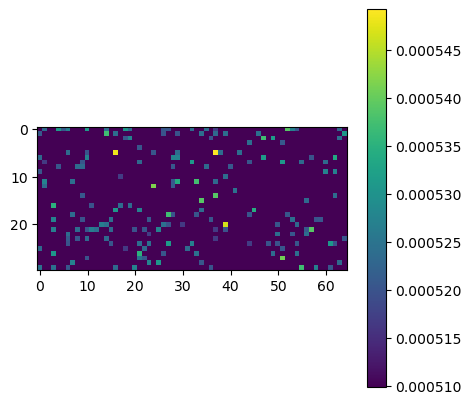

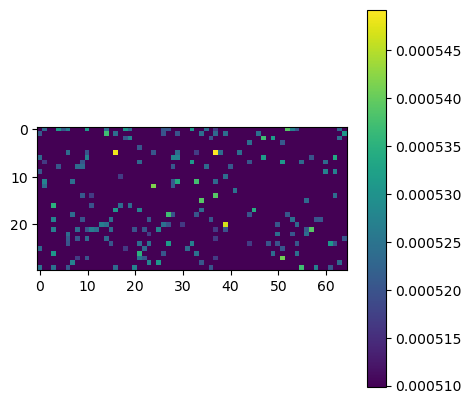

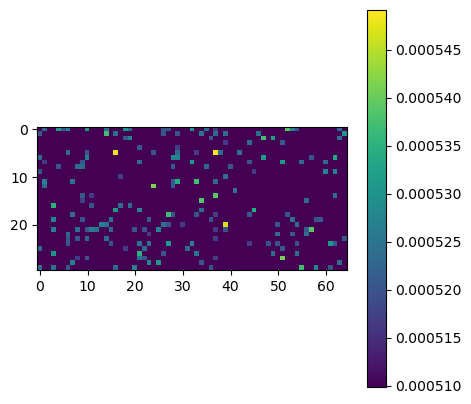

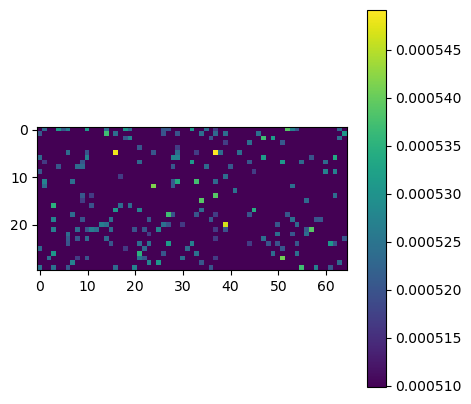

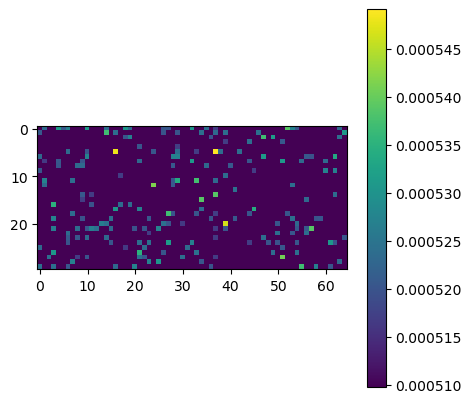

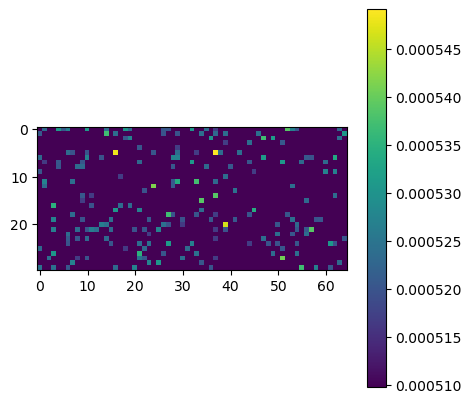

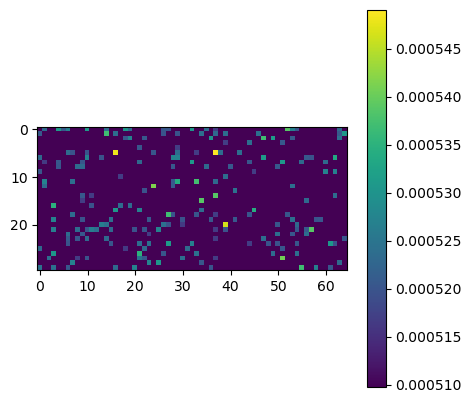

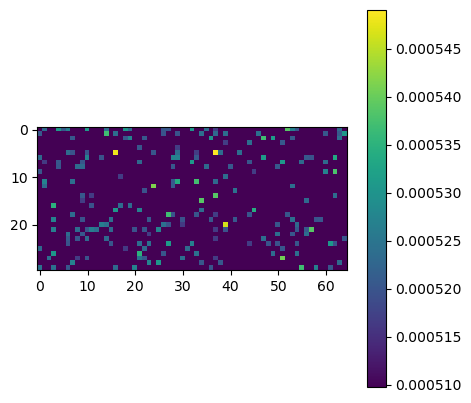

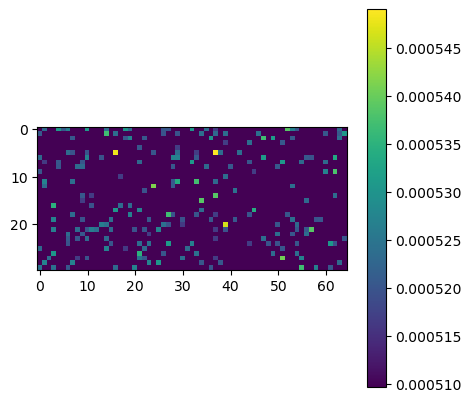

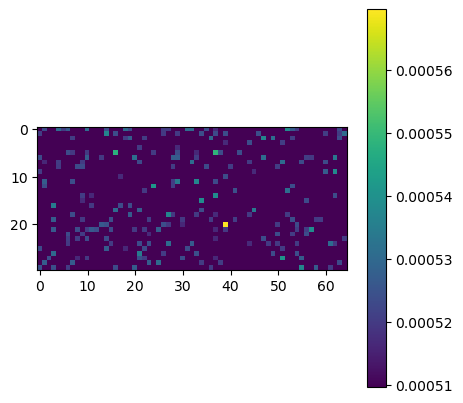

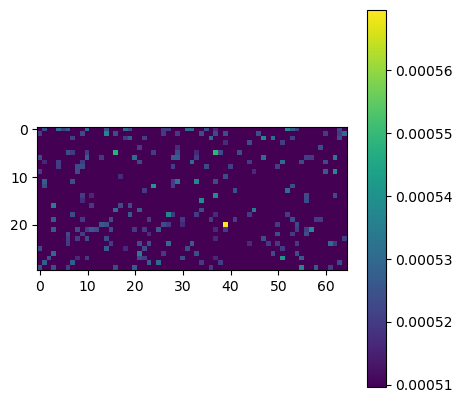

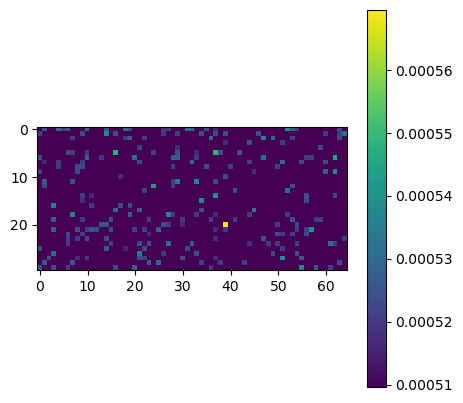

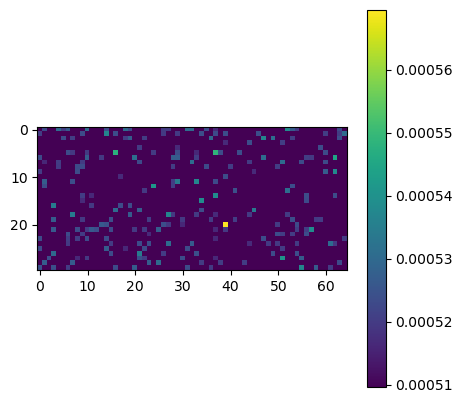

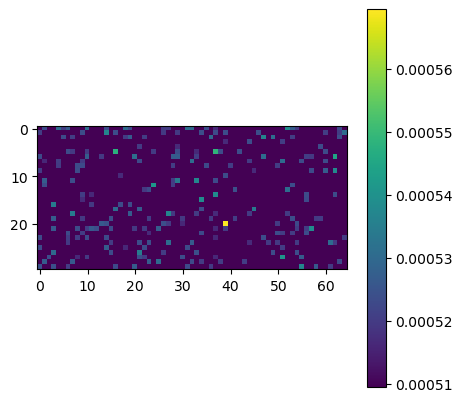

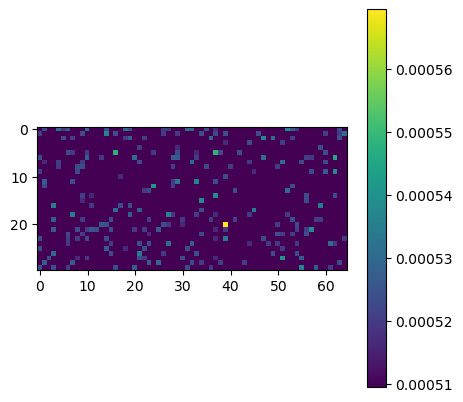

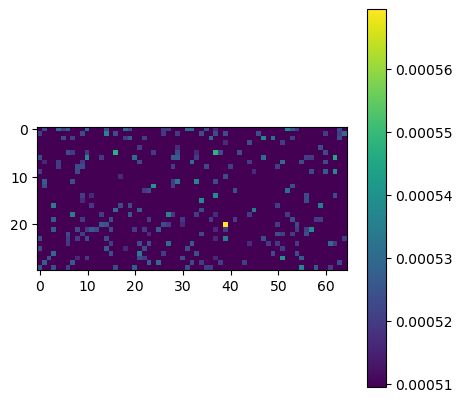

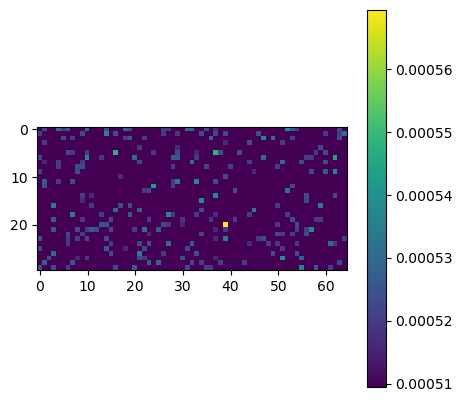

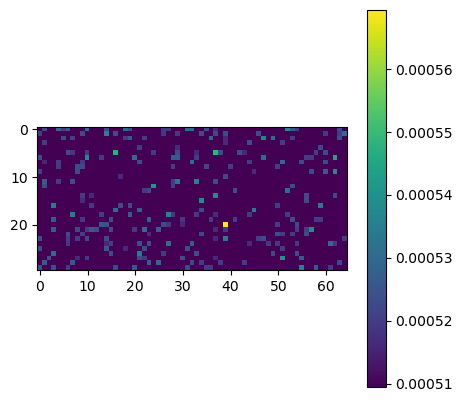

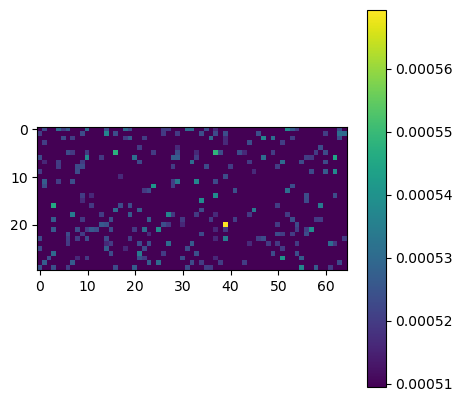

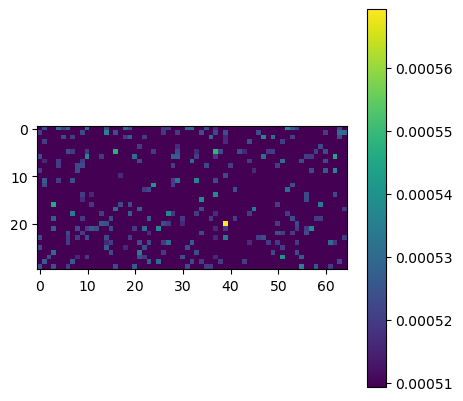

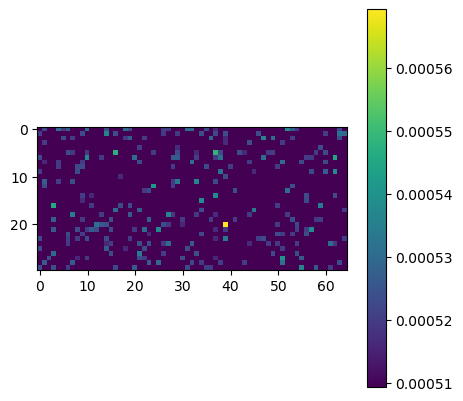

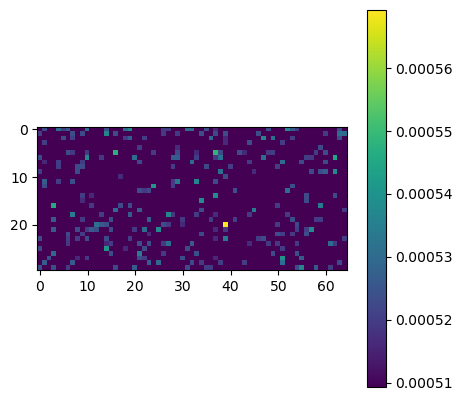

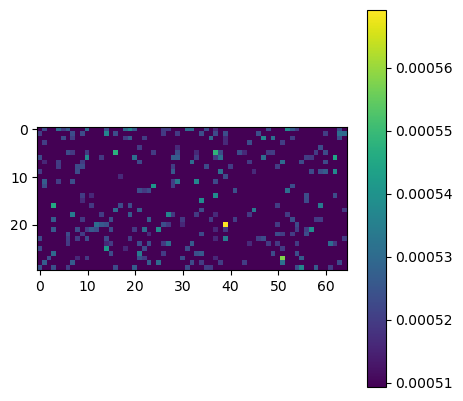

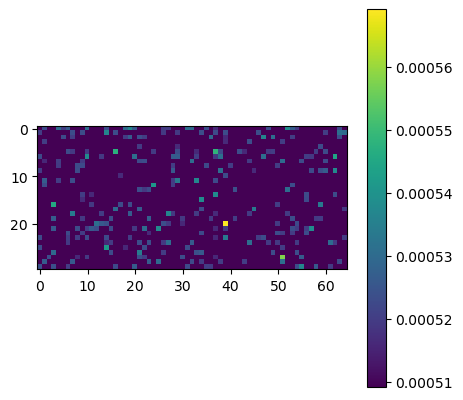

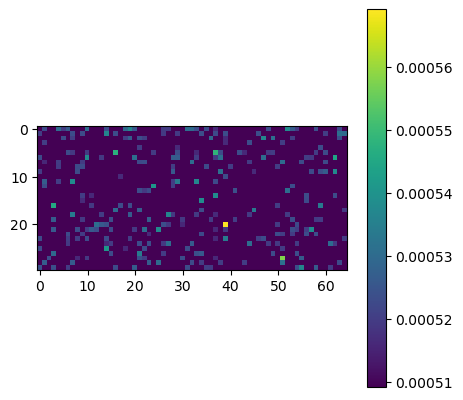

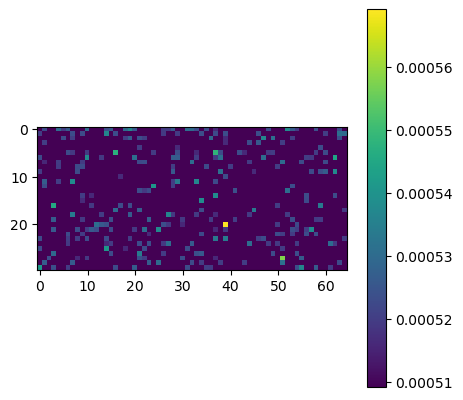

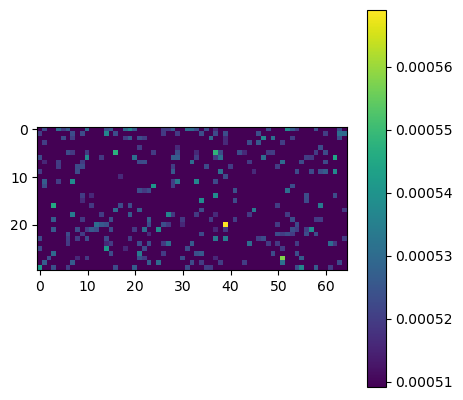

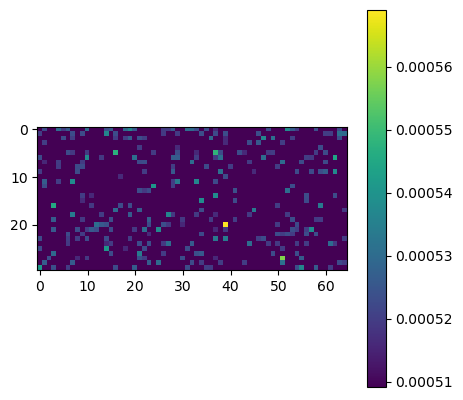

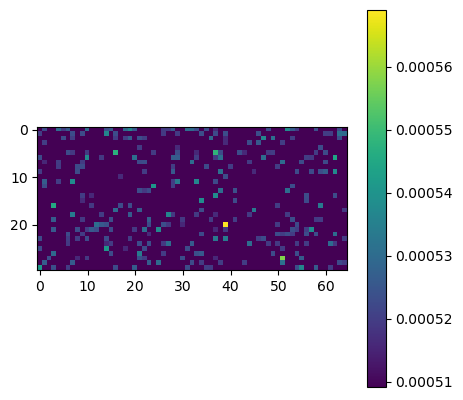

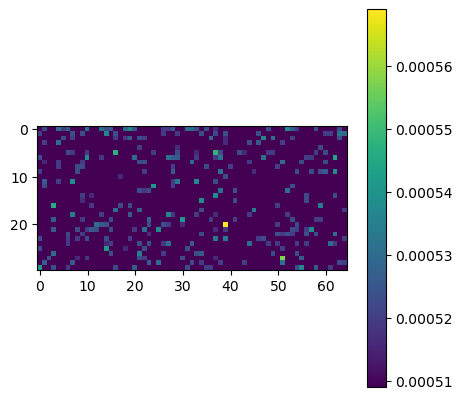

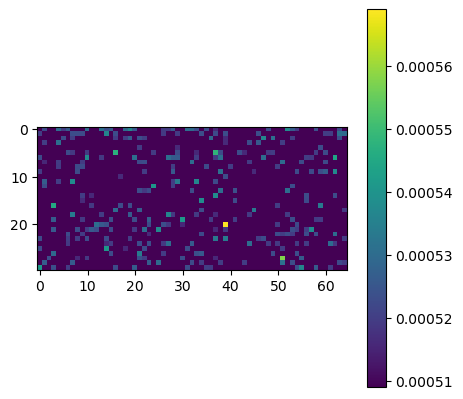

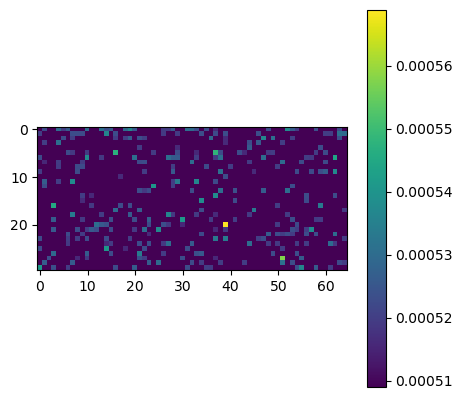

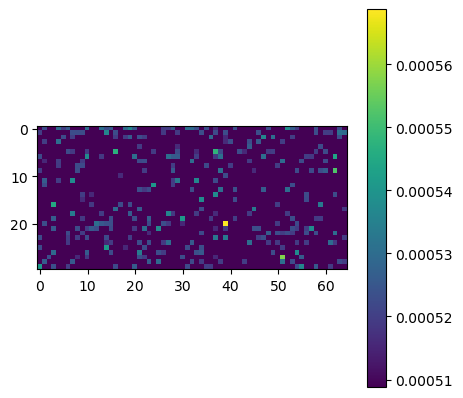

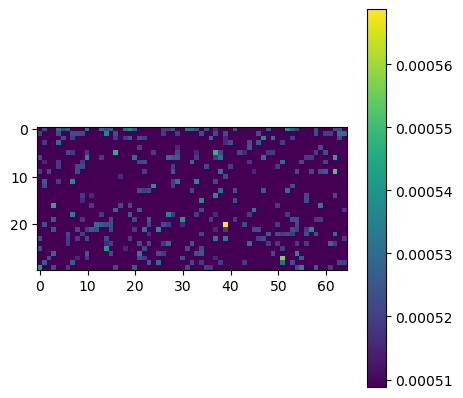

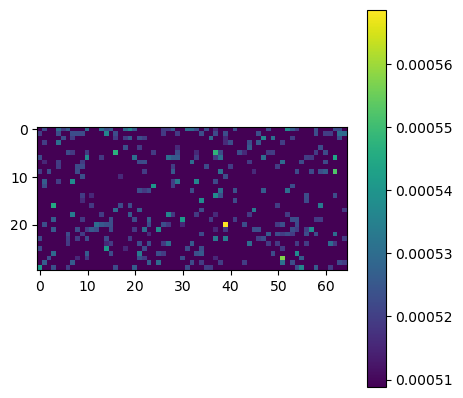

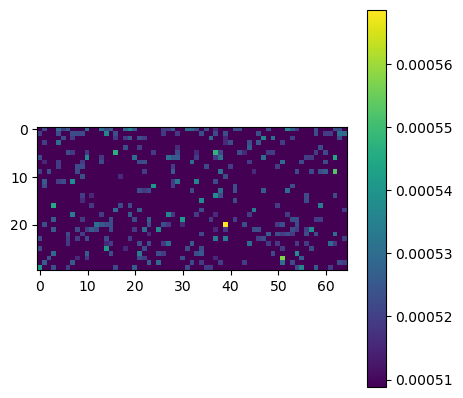

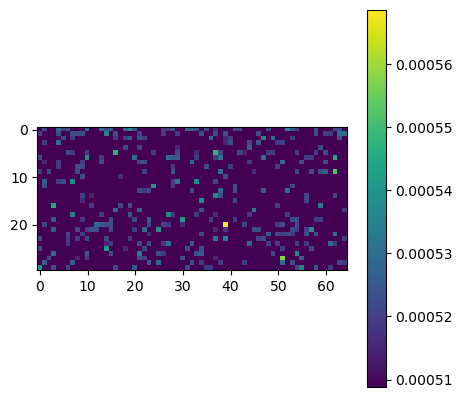

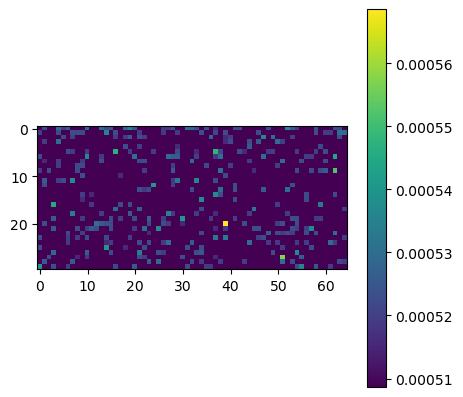

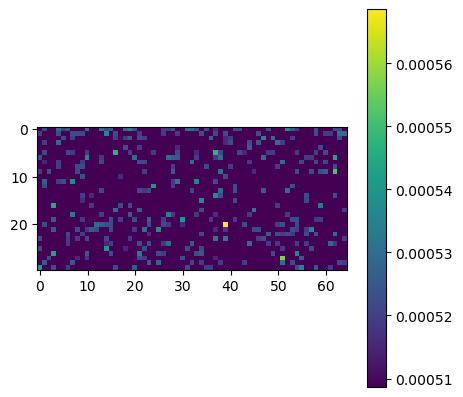

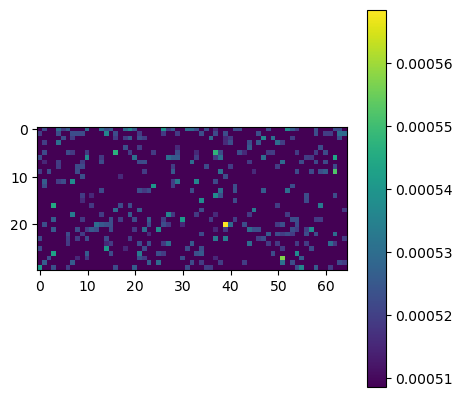

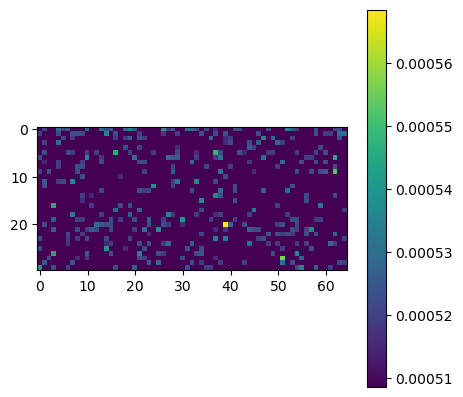

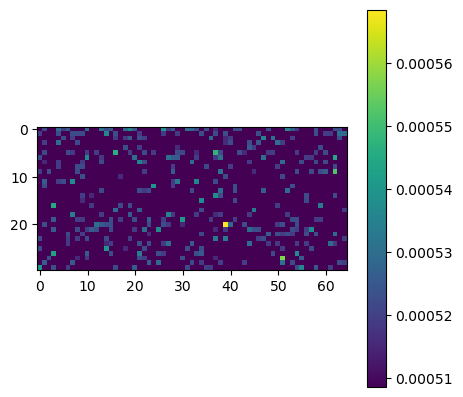

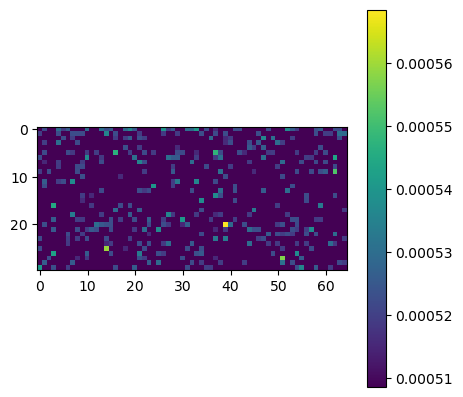

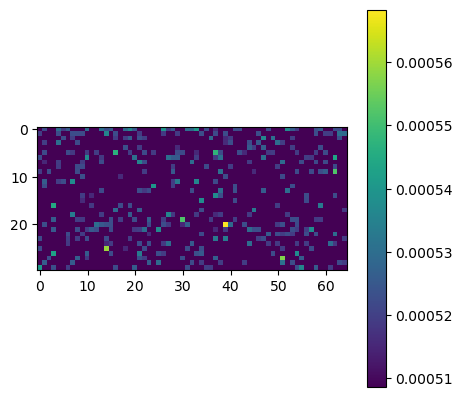

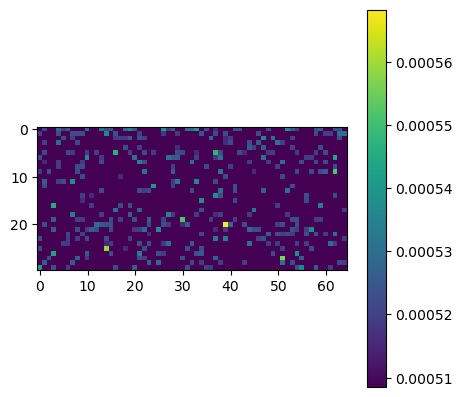

In [136]:
win = Window(title="Algorithm run",geometry="800x1000")
win.label("Now we run the actual program. Enter the required hyperparameters below:")

min_coverage = IntVar(value=10)
win.label("\nmin_coverage:")
ttk.Entry(win.frame,width=7,textvariable=min_coverage).pack()
max_uncovered = IntVar(value=10)
win.label("\nmax_uncovered:")
ttk.Entry(win.frame,width=7,textvariable=max_uncovered).pack()
n_ants = IntVar(value=500)
win.label("\nn_ants:")
ttk.Entry(win.frame,width=7,textvariable=n_ants).pack()
max_dups = IntVar(value=1)
win.label("\nmax_dups:")
ttk.Entry(win.frame,width=7,textvariable=max_dups).pack()
chance_murder_ant = IntVar(value=10)
win.label("\nNumber of tries for each ant:")
ttk.Entry(win.frame,width=7,textvariable=chance_murder_ant).pack()

run = ttk.Button(text="Run",command=Worldgen)
run.pack()


win.w.mainloop()

In [ ]:
np.save('rules.npy', world.discovered_rule_list)

In [ ]:
np.load('rules.npy', allow_pickle=True)

In [ ]:
n_corrects = 0
n_matches = 0
for rule in world.discovered_rule_list:
    n_corrects += len(rule.correct_set())
    n_matches += len(rule.match_set)
    
n_corrects, n_matches, 100*n_corrects/n_matches

In [ ]:
from collections import defaultdict

In [ ]:
def predict(row):
    matching_rules = []
    instance = dict(row)
    
    preddict = defaultdict(lambda: 0)
    for rule in world.discovered_rule_list:
        if rule.match(instance):
            preddict[rule.emotion] += 1
            
    if preddict:
        return max(preddict, key=preddict.get)
    return 'unable to predict'

In [ ]:
disc2 = discreet.copy(deep=True)
disc2.columns = range(len(discreet.columns))
disc2.rename(columns={652: 'class'}, inplace=True)
#disc2

In [ ]:
disc2['preds'] = 'nothing'

In [ ]:
disc2.at[1143, 'preds'] = predict(disc2.drop(['preds', 'class'], axis=1).iloc[1143])

In [ ]:
disc2['preds'][1143]

In [ ]:
for i, row in enumerate(disc2.iterrows()):
    disc2.at[i, 'preds'] = predict(disc2.drop(['preds', 'class'], axis=1).iloc[i])
#disc2

In [ ]:
correct = disc2.loc[disc2['class'] == disc2['preds']]
predicted = disc2.loc[disc2['preds'] != 'unable to predict']
len(correct), len(predicted), len(correct)/len(predicted), len(correct)/len(disc2)

In [ ]:
disc2['class'].value_counts()

In [ ]:
correct['class'].value_counts()

# From here it's just random testing

In [ ]:
np.unique(np.random.choice(4, 1000, p=[0, 0.33, 0.33, 0.34]), return_counts=True)

In [ ]:
x = len(features) - 0
Eta = logK - H
denom = x * np.sum(Eta, axis=0)
Eta = np.divide(Eta, denom)

T = np.random.rand(H.shape[0], H.shape[1])
Probs = np.multiply(Eta, T)
denom = x * np.sum(Probs, axis=0)
Probs = np.divide(Probs, denom)
np.sum(Probs)

In [ ]:
flattened = Probs.flatten()
num = np.random.choice(len(flattened), 1, p=flattened)
col = num % 652
row = num // 652
int(col), int(row)